In [12]:
%load_ext autoreload
%autoreload 2

import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import FoVPerspectiveCameras
from text3d2video.util import read_obj_uvs
from text3d2video.utilities.mesh_processing import normalize_meshes
from matplotlib import pyplot as plt
from torchvision.io import read_image
import torchvision.transforms.functional as TF

torch.set_grad_enabled(False)

# read mesh
mesh_path = "data/meshes/mixamo-human.obj"

device = "cpu"
meshes = load_objs_as_meshes([mesh_path], device=device)
meshes = normalize_meshes(meshes)
verts_uvs, faces_uvs = read_obj_uvs(mesh_path, device=device)

print("verts", meshes.verts_list()[0].shape)
print("faces", meshes.faces_list()[0].shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
verts torch.Size([14442, 3])
faces torch.Size([28880, 3])


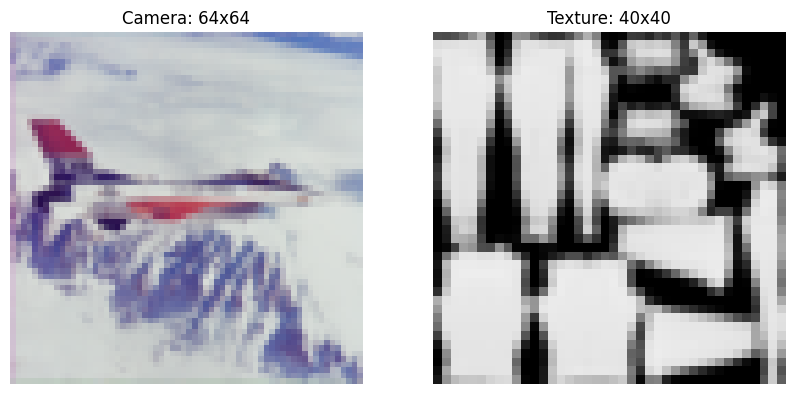

In [4]:
TEXTURE_RES = 40
CAMERA_RES = 64

texture_image = read_image("data/meshes/mixamo-human_uvs.png") / 255
texture_image = TF.resize(texture_image, (TEXTURE_RES, TEXTURE_RES))
texture_image = texture_image[0:3, :, :]
texture_image = texture_image.permute(1, 2, 0).to(device)

camera_image = read_image("data/images/airplane.png") / 255
camera_image = TF.resize(camera_image, (CAMERA_RES, CAMERA_RES))
camera_image = camera_image.permute(1, 2, 0).to(device)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax_tex = axs[1]
ax_cam = axs[0]

ax_tex.set_title(f"Texture: {TEXTURE_RES}x{TEXTURE_RES}")
ax_tex.imshow(texture_image.cpu().numpy())

ax_cam.set_title(f"Camera: {CAMERA_RES}x{CAMERA_RES}")
ax_cam.imshow(camera_image.cpu().numpy())

for ax in axs:
    ax.axis("off")

(-0.5, 99.5, 99.5, -0.5)

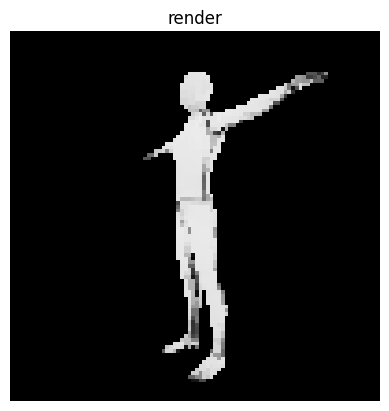

In [6]:
from text3d2video.rendering import (
    make_mesh_renderer,
    make_repeated_uv_texture,
)
from text3d2video.utilities.camera_placement import turntable_extrinsics

R, T = turntable_extrinsics(angles=60, dists=1)
cam = FoVPerspectiveCameras(R=R, T=T, device=device, fov=65)

render_meshes = meshes.clone()
render_meshes.textures = make_repeated_uv_texture(
    texture_image, faces_uvs, verts_uvs, sampling_mode="nearest"
)

renderer = make_mesh_renderer(resolution=100)
render = renderer(render_meshes, cameras=cam)

plt.title("render")
plt.imshow(TF.to_pil_image(render[0].cpu()))
plt.axis("off")

## Compute Pixel-UV continuous mapping

In [7]:
from text3d2video.backprojection import project_visible_texels_to_camera

texel_xys, texel_uvs = project_visible_texels_to_camera(
    meshes, cam, verts_uvs, faces_uvs, raster_res=100, texture_res=TEXTURE_RES
)

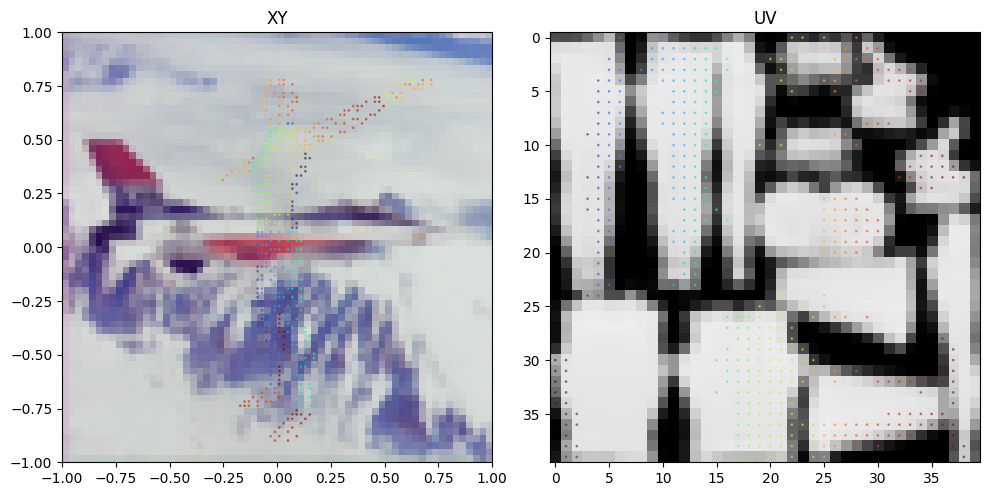

In [8]:
indices = torch.arange(0, texel_xys.shape[0], device=device)

cmap = "turbo"
s = 1
alpha = 0.5

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax_xy = axs[0]
ax_uv = axs[1]

ax_xy.imshow(camera_image.cpu().numpy(), extent=(-1, 1, -1, 1))
ax_xy.set_xlim(-1, 1)
ax_xy.set_ylim(-1, 1)
ax_xy.set_title("XY")

ax_xy.scatter(
    texel_xys[:, 0].cpu(),
    texel_xys[:, 1].cpu(),
    s=s,
    c=indices.cpu(),
    cmap=cmap,
    alpha=alpha,
)

ax_uv.imshow(texture_image.cpu().numpy())
ax_uv.scatter(
    texel_uvs[:, 0].cpu(),
    texel_uvs[:, 1].cpu(),
    s=s,
    c=indices.cpu(),
    cmap=cmap,
    alpha=alpha,
)
ax_uv.set_title("UV")

plt.tight_layout()
plt.show()

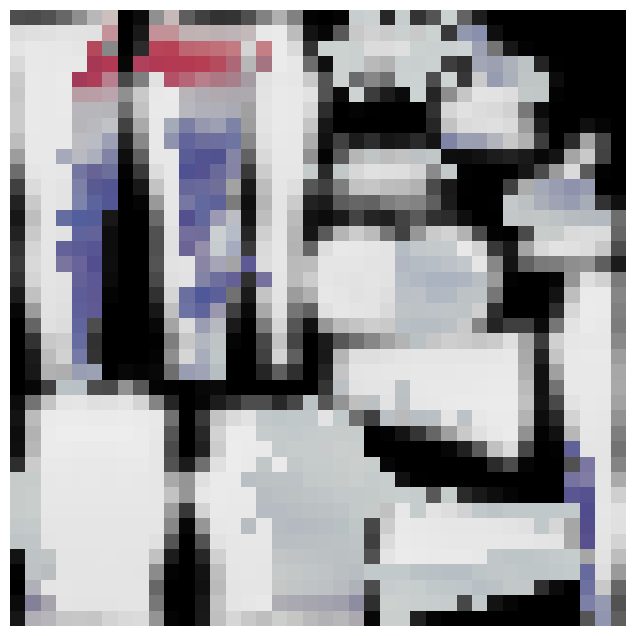

<Figure size 640x480 with 0 Axes>

In [9]:
from text3d2video.backprojection import update_uv_texture
from text3d2video.ipython_utils import display_ims

camera_fmap = camera_image.permute(2, 0, 1)

updated_texture = texture_image.clone()
updated_texture = update_uv_texture(
    updated_texture, camera_fmap, texel_xys, texel_uvs, update_empty_only=False
)

display_ims([updated_texture.cpu()], scale=8)

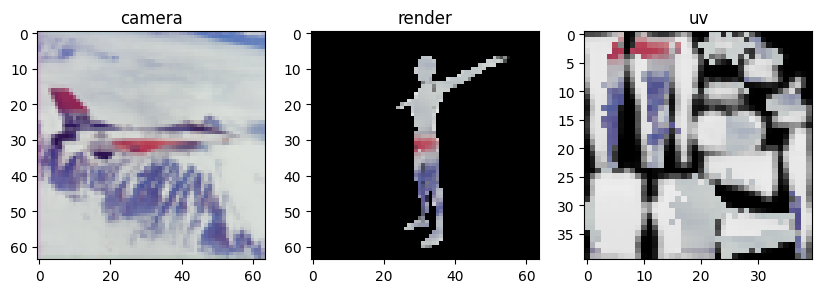

In [10]:
from text3d2video.rendering import make_mesh_renderer, make_repeated_uv_texture

textures = make_repeated_uv_texture(updated_texture, faces_uvs, verts_uvs)
renderer = make_mesh_renderer(resolution=CAMERA_RES)

render_meshes = meshes.clone()
meshes.textures = textures
render = renderer(meshes, cameras=cam)

# plot 
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
ax_cam = axs[0]
ax_render = axs[1]
ax_uv = axs[2]

ax_render.set_title("render")
ax_render.imshow(render[0].cpu().permute(1, 2, 0))

ax_cam.set_title("camera")
ax_cam.imshow(camera_image.cpu())

ax_uv.set_title("uv")
ax_uv.imshow(updated_texture.cpu())

# Projection, rendering and re-projection

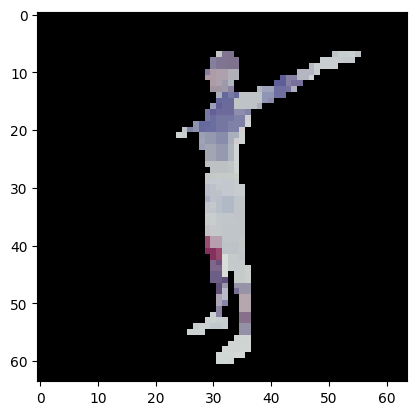

In [43]:
dtype = torch.float16
device = "cpu"

uv_res = 20
texture = read_image("data/images/airplane.png") / 255
texture = TF.resize(texture, (uv_res, uv_res))
texture = texture.permute(1, 2, 0).to(device)

mesh = meshes[0]

render_meshes = mesh.clone()
render_meshes.textures = make_repeated_uv_texture(
    texture,
    faces_uvs,
    verts_uvs,
    sampling_mode="nearest",
    N=len(render_meshes),
)
rendered = renderer(render_meshes, cameras=cam)
# rendered = rendered.to(dtype=dtype, device=device)

denoised = rendered * 2

plt.imshow(rendered[0].permute(1, 2, 0).cpu())

In [44]:
update_uv_texture(
    texture,
    denoised[0],
    texel_xys,
    texel_uvs,
    update_empty_only=False,
    interpolation="nearest",
)
...

IndexError: index 30 is out of bounds for dimension 0 with size 20

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.656442].


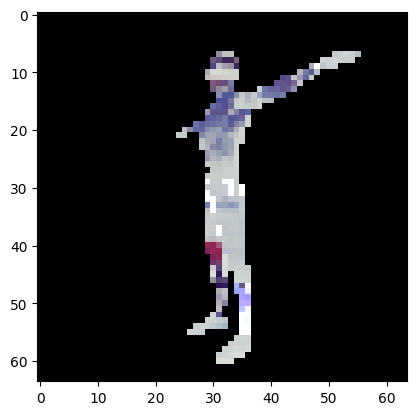

In [41]:
render_meshes = mesh.clone()
render_meshes.textures = make_repeated_uv_texture(
    texture,
    faces_uvs,
    verts_uvs,
    sampling_mode="nearest",
    N=len(render_meshes),
)
rendered = renderer(render_meshes, cameras=cam)
# rendered = rendered.to(dtype=dtype, device=device)

plt.imshow(rendered[0].permute(1, 2, 0).cpu())